<a href="https://colab.research.google.com/github/Christelleelkhoury/AI-for-Med.Diagnos.-Prediction/blob/main/Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - AI for Medical Diagnosis and Prediction | Week #3

In this notebook, we continue our analysis of the MIMIC-CXR dataset by training our first classifiers. The objective is to perform a benchmark analysis of several machine learning classifiers to detect the presence of pathologies in chest x-rays.

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Create two subsets of the dataset: train and test <i>(Task 1)</i> <br>
- Prepare a list of models and hyperparameters to investigate during optimization <i>(Task 2)</i> <br>
- Implement the search using the cross-validation strategy of your choice <i>(Task 2*)</i> <br>
- Add an evaluation of data augmentation strategies as part of your optimization process <i>(Task 3)</i> <br>
- Run the benchmark analysis, save the results in a csv file using various appropriate metrics <i>(Task 4)</i> <br>
- Save the best model on the validation set <i>(Task 5)</i> <br>
- Compute the performance of this best model on the test set <i>(Task 5*)</i> <br>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [1]:
%pip install pydicom pynrrd -q
%pip install -q SimpleITK numpy PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import pydicom
import nrrd

import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
import warnings

warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = './MIMIC-CXR'

In [4]:
!curl https://uni-bonn.sciebo.de/s/XbomHCb6yL6nYN4/download/radiomics.csv --output ./radiomics.csv
!curl https://uni-bonn.sciebo.de/s/e7fKPxDYcs83J67/download/labels.csv --output ./labels.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1256k  100 1256k    0     0   749k      0  0:00:01  0:00:01 --:--:--  749k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63894  100 63894    0     0  66747      0 --:--:-- --:--:-- --:--:-- 66695


If you do not have the dataset anymore, please re-run the notebook from week 2. Here, we will use the csv file created during week 2: `radiomics.csv` which contains input features and target classes.

In [5]:
df = pd.read_csv(f'radiomics.csv')
labels_df = pd.read_csv(f'labels.csv')

In [6]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject_id,study_id,dicom_path,dicom_id,labels_encoded,pathology
0,-1.278524,0.855135,3.209739e+06,0.847227,1.163292,2.215956,1.373047,0.651548,-0.435326,-0.660705,...,0.000056,0.008836,0.001758,0.000056,18000291,55388853,files/p18/p18000291/s55388853/04564240-d4e9e69...,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
1,-1.313175,0.854954,3.300384e+06,0.839250,1.167722,2.261075,1.385948,0.657629,-0.451919,-0.669476,...,0.000060,0.008285,0.001627,0.000060,18000291,55388853,files/p18/p18000291/s55388853/ed82a88d-499bed8...,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
2,-1.128694,0.825043,9.963108e+05,0.868463,1.128072,2.452143,1.815657,0.622337,-0.358779,-0.610935,...,0.000126,0.010801,0.002224,0.000126,18000379,51062789,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
3,-1.029863,1.083006,1.473029e+06,0.993817,1.266049,1.926242,1.567053,0.647344,-0.021913,-0.097315,...,0.000052,0.015052,0.003731,0.000052,18000379,51568340,files/p18/p18000379/s51568340/3631ff3b-cfcb244...,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
4,-0.821600,1.128441,1.440104e+06,0.999173,1.235120,1.865436,1.651462,0.626043,0.091044,0.045712,...,0.000040,0.018150,0.004532,0.000040,18000379,51817182,files/p18/p18000379/s51817182/f6f04111-c3fde25...,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,[1 0 0 0 0 0 0 0 0 0 0 0 0 1],1


## Task 1 - Dataset split
* Get the list of **UNIQUE** patients ;
* Split the list into train and test patients ;
* Extract two datasets: `train_df` and `test_df`

In [7]:
patient_list = df['subject_id'].unique()

In [8]:
from sklearn.model_selection import train_test_split

patient_train, patient_test = train_test_split(
    patient_list, # List or array to split
    test_size=0.3, # Size of the subset
    random_state=42)

In [9]:
train_df = df.loc[df['subject_id'].isin(patient_train)]
test_df = df.loc[df['subject_id'].isin(patient_test)]

train_labels_df = labels_df.loc[labels_df['subject_id'].isin(patient_train)]
test_labels_df = labels_df.loc[labels_df['subject_id'].isin(patient_test)]

train_labels_df.to_csv('train_labels.csv', index=False)
test_labels_df.to_csv('test_labels.csv', index=False)

In [10]:
train_df['pathology'].value_counts()

,count
pathology,
0,247
1,238


In [11]:
test_df['pathology'].value_counts()

,count
pathology,
1,102
0,82


In [12]:
X_train = train_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology'], axis=1)
y_train = train_df['pathology']

X_test = test_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology'], axis=1)
y_test = test_df['pathology']

## Task 2 - Models and hyperparameters

* Define the list of models and hyperparameters you want to benchmark ;
* Implement the cross-validation strategy of your choice ;
* Create the searcher and run the benchmark analysis.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Define models and hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), {
        'classifier__C': [0.01, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear']
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [10, 30, 50],
        'classifier__max_depth': [None, 5, 10]
    }),
    'Nearest Neighbors': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [5, 10, 20]
    }),
    #'MLP': (MLPClassifier(), {
    #    'classifier__hidden_layer_sizes':[100, 50, 15],
    #    'classifier__alpha':[0.01, 0.1, 0.5, 1]
    #})
}

# Use StratifiedKFold for cross-validation to maintain class proportions
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []
results_smote = []

In [14]:
# Run benchmark with hyperparameter tuning (without SMOTE)
for name, (model, param_dist) in models.items():
    # Create a pipeline with StandardScaler and the classifier.
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10,
                                scoring='recall', cv=cv, random_state=42, n_jobs=-1, error_score='raise')

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_score = search.best_score_
    std_dev = search.cv_results_['std_test_score'][search.best_index_]

    # Save best model into pkl format
    joblib.dump(best_model, f'best_model_{name.replace(" ", "_").lower()}.pkl')

    results.append({
        'Model': name,
        'Mean score': best_score,
        'Std Dev': std_dev
    })

## Task 3 - Data augmentation

* Add a data augmentation step in the pipeline, for instance using SMOTE ;
* Run the benchmark analysis using the data augmentation step.

In [15]:
# Run benchmark with hyperparameter tuning, scaling, and SMOTE
for name, (model, param_dist) in models.items():
    # Create a full pipeline with StandardScaler, SMOTE, and the classifier.
    # This is the correct order of operations.
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10,
                                scoring='recall', cv=cv, random_state=42, n_jobs=-1, error_score='raise')

    search.fit(X_train, y_train)

    # search.best_estimator_ is the entire tuned pipeline
    best_pipeline = search.best_estimator_
    best_score = search.best_score_
    std_dev = search.cv_results_['std_test_score'][search.best_index_]

    # Save the best pipeline (scaler + smote + model)
    joblib.dump(best_pipeline, f'best_model_smote_{name.replace(" ", "_").lower()}.pkl')

    results.append({
        'Model': name + ' SMOTE',
        'Mean score': best_score,
        'Std Dev': std_dev
    })

## Task 4 - Model selection

* Analyse the results provided by the benchmark analysis and select the best model ;
* Visualize different scores and comment.

In [16]:
# Create results table
df_results = pd.DataFrame(results).sort_values(by='Mean score', ascending=False)

print("Benchmark Results:")
print(df_results)

# Optionally: save to CSV
#df_results.to_csv('model_benchmark_results_smote.csv', index=False)

Benchmark Results:
                       Model  Mean score   Std Dev
4        Random Forest SMOTE    0.743776  0.014247
1              Random Forest    0.714293  0.015555
0        Logistic Regression    0.710021  0.037693
3  Logistic Regression SMOTE    0.709968  0.036611
5    Nearest Neighbors SMOTE    0.668143  0.020123
2          Nearest Neighbors    0.659652  0.002014


## Task 5 - Evaluation

* Load the selected model ;
* Make a full performance report (ROC curve, metrics, confusion matrices) of the selected model.

In [17]:
from sklearn.metrics import classification_report
# Load a specific model (e.g., Logistic Regression without SMOTE)
best_model = joblib.load('best_model_random_forest.pkl')

# Use it for predictions
predictions = best_model.predict(X_test)

# Get classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.63      0.60        82
           1       0.68      0.62      0.65       102

    accuracy                           0.62       184
   macro avg       0.62      0.63      0.62       184
weighted avg       0.63      0.62      0.63       184



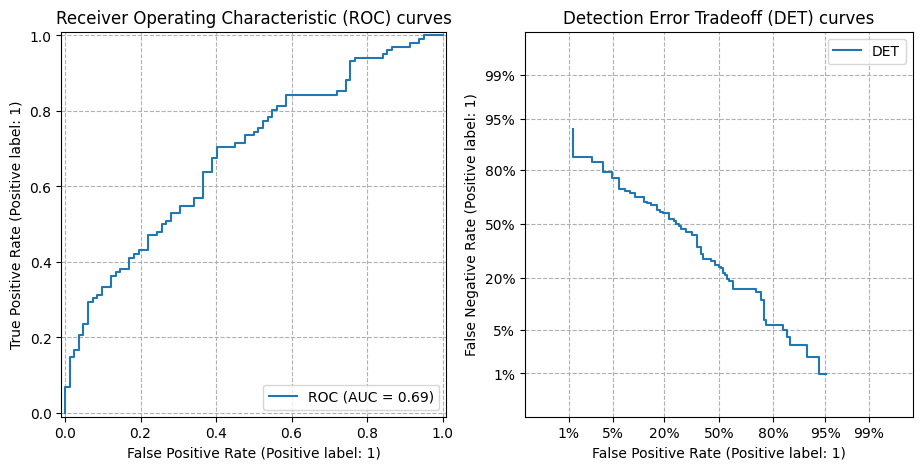

In [18]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_roc, name='ROC')
DetCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_det, name='DET')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()

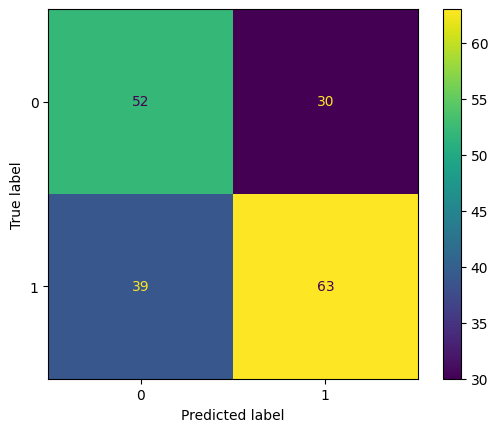

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)
disp.plot()
plt.show()

In [20]:
from sklearn.metrics import classification_report

best_model = joblib.load('best_model_logistic_regression.pkl')

# Use it for predictions
predictions = best_model.predict(X_test)

# Get classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64        82
           1       0.72      0.58      0.64       102

    accuracy                           0.64       184
   macro avg       0.65      0.65      0.64       184
weighted avg       0.66      0.64      0.64       184



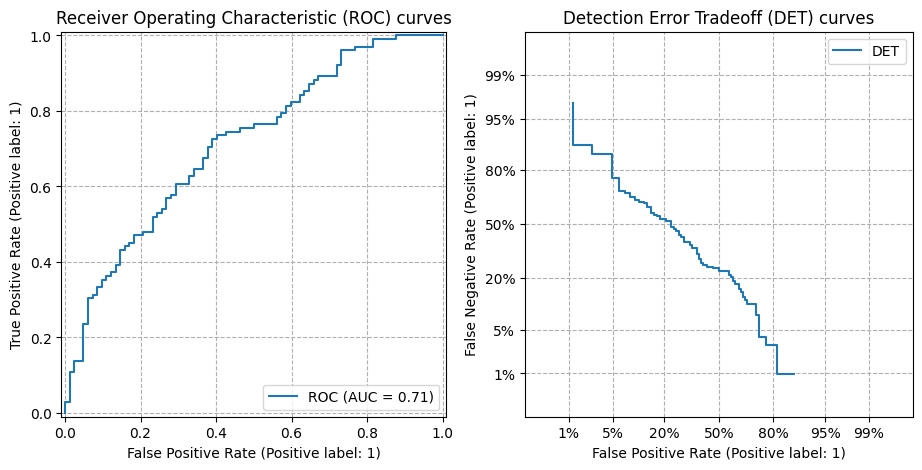

In [21]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_roc, name='ROC')
DetCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_det, name='DET')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()

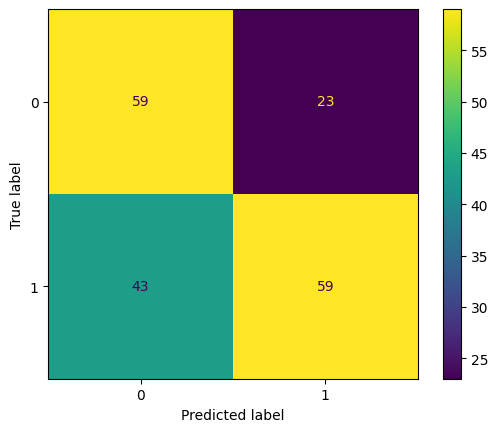

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)
disp.plot()
plt.show()